# Preparativos

## Importando bibliotecas

In [1]:
import basedosdados as bd
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

project_id="ce042marciobulla"

## Organizando dados

Notei que para importar os dados usando a biblioteca `basedosdados` é muito lento pela abundancia de informação. Desta forma, farei uma query para criar uma table com os dados necessarios para minha analise. Com isso elecarei cada tabela do database e discutirei as informações uteis de cada uma.

olhando o dadaset como um todo vemos que há $3$ tabelas uteis para nosso trabalho de indetificar o partido do candidato. Além disso, vimos que a variavel que relacionaremos as informações entre as tabelas é o `id_candidato_db` desta foram podemos avaliar dados a partir de $2006$, pois os bens do candidato são só informados depois desse ano.


## Contruindo dados para analise

Precisamos avaliar cada coluda de tabela e definir as colunas (Features) desejadas para a analise.



`bens_candidato`
- `id_candidato_db` index
- `valor_item`
- `ano`
- `tipo_eleicao`


`candidatos`
- `id_candidato_bd` index
- `ano`
- `genero`
- `sigla_uf_nacimento`
- `sigla_partido` TARGET
- `raca`
- `instrucao`
- `estado_civil`

`Despesas_cadidato`
- `id_candidato_bd` index
- `tipo_eleicao`
- `valor_despesa`
- `tipo_prestacao_contas`
- `sigla_uf`
- `nome_partido`
- `tipo_eleicao`
- `sigla_uf`

Antes de montarmos a querys devos entender um pouco melhor os dados. Pois temos algumas perguntas sobre as colunas:

- Será que o candidato tem um id diferente por canditatura?
Para isso faremos um `group by` na coluna `id_cadidato_db` de cada tabela e checaremos se há multiplos anos para cada id.

Com essa resposta saberemos melhor como lidaremos com os dados e se utilizaremos o `id_candidato_db`como index em comum entre as tabelas (Primary Key).

In [2]:
def check_id_bd(table):
    query = f"""
    SELECT 
        id_candidato_bd,
        COUNT(DISTINCT ano) AS anos_{table[:3]}
    FROM 
        `basedosdados.br_tse_eleicoes.{table}` 
    WHERE
        ano >= 2006 AND
        id_candidato_bd IS NOT NULL
    GROUP BY 
        id_candidato_bd
    ORDER BY
        anos_{table[:3]} DESC,
        id_candidato_bd ASC
    LIMIT
        1000
    """
    return bd.read_sql(query, billing_project_id="ce042marciobulla")

In [3]:
df_candidato_temp = check_id_bd("candidatos")
df_bens_temp = check_id_bd("bens_candidato")
df_despesas_temp = check_id_bd("despesas_candidato")

Downloading: 100%|██████████████████████| 1000/1000 [00:00<00:00, 2046.57rows/s]


In [4]:
df = df_candidato_temp.merge(df_bens_temp, how ='inner', 
                                        ).merge(
                                        df_despesas_temp, how ='inner')
df[(df.anos_can != df.anos_ben) |
   (df.anos_can != df.anos_des) |
   (df.anos_ben != df.anos_des)].head()

,id_candidato_bd,anos_can,anos_ben,anos_des
5,1263633,9,8,9
7,1362073,9,8,9
8,1386540,9,9,8
9,1418973,9,8,9
10,1428461,9,8,9


Por motivos computacionais peguei apenas 1000 candidatos. Mas podemos entender um pouco melhor a coluna ano, veja que, tem momentos que há anos que o canditado não declara os bens ou dispesas. De qualquer forma, vemos que `id_candidato_bd` é um otimo index para relacionar as tabelas a partir de $2006$.

Além disso, poderá ter partidos que não existem em 2022, ou seja, não é util para o modelo, pois qualquer futuro canditado não sera deste partido.

# Analises

Com isso podemos montar querys para cada tabela onde podemos explorar os comportamentos de candidatos. Vamos utilizar a tabela `candidatos` como referencial, pois essa é a tabela que detem as informações pessoas de cada candidato.

In [5]:
cond_target = """
ano>=2006 AND
sigla_partido IN (
    SELECT 
        sigla_partido
    FROM
        basedosdados.br_tse_eleicoes.candidatos
    WHERE 
        ano = 2022
    GROUP BY
        sigla_partido
                    )
"""

Com essa condição pegamos somente os partidos que ainda existem. A primeira coisa que podemos vizualizar é a quantidade de candidatos por partido.

In [6]:
origin = "basedosdados.br_tse_eleicoes."
tb_candidatos = origin + "candidatos"
tb_bens = origin + "bens_candidato"
tb_dispesas = origin + "Despesas_cadidato"

def read_sql(query):
    global project_id
    return bd.read_sql(query, billing_project_id=project_id)

## Table: `candidatos`

In [7]:
query = f"""
SELECT
    sigla_partido,
    COUNT(DISTINCT id_candidato_bd) AS candidatos_partido
FROM
    basedosdados.br_tse_eleicoes.candidatos
WHERE
    {cond_target}
GROUP BY 
    sigla_partido
ORDER BY
    candidatos_partido DESC
"""
df_candidatos = bd.read_sql(query, billing_project_id=project_id)

Downloading: 100%|███████████████████████████| 32/32 [00:00<00:00, 103.03rows/s]


Text(0.5, 1.0, 'Numero de candidatos que já passaram pelo partido')

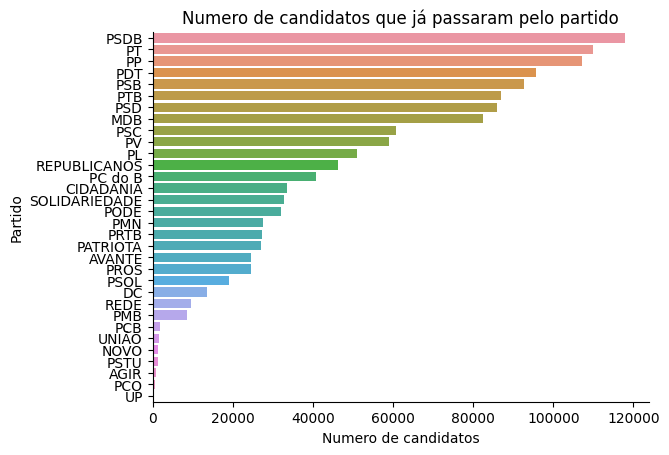

In [8]:
g = sns.barplot(df_candidatos, y="sigla_partido", x="candidatos_partido")
sns.despine()
g.set_xlabel("Numero de candidatos")
g.set_ylabel("Partido")
g.set_title("Numero de candidatos que já passaram pelo partido")

In [9]:
df_candidatos.tail(10)

,sigla_partido,candidatos_partido
22,DC,13501
23,REDE,9494
24,PMB,8521
25,PCB,1894
26,UNIÃO,1526
27,NOVO,1455
28,PSTU,1328
29,AGIR,952
30,PCO,626
31,UP,173


Vemos que muito paritdos tem menos amostras distintas, pelo fato de serem novos. O qual é o caso do UP, AGIR, NOVO e outros.

Alem disso provavelmente pessoas que tentaram mais vezes são de partido mais antigos, vamos avaliar isso com um `boxplot`


### Numero de candidatações?
Influencia o partido que está, é claro que essa pergunta pode ser influeciada pela idade do partido. Mas podemos vizualiar se esse partido novos tem pessoas que ja trocaram de partido.

In [10]:
query = f"""
SELECT
    id_candidato_bd,
    sigla_partido,
    count(DISTINCT ano) AS tentativas,
FROM
    {tb_candidatos}
WHERE
    {cond_target}
GROUP BY
    id_candidato_bd,
    sigla_partido
"""

df_tentativas = read_sql(query)


Downloading: 100%|███████████████| 1325356/1325356 [02:05<00:00, 10584.61rows/s]


In [11]:
df_tentativas = df_tentativas.groupby("sigla_partido").tentativas.value_counts().unstack()
df_tentativas.fillna(0, inplace=True)


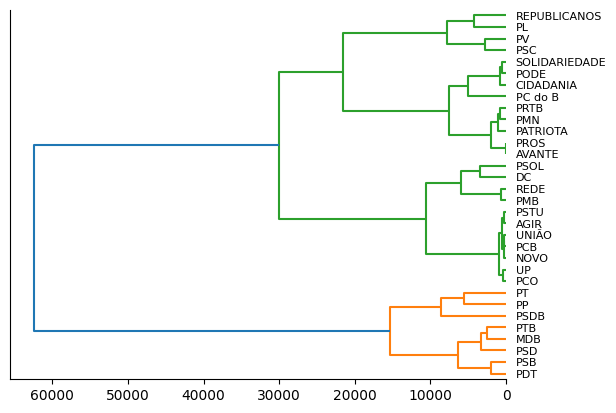

In [12]:
Z = hierarchy.linkage(df_tentativas, method="centroid")
hierarchy.dendrogram(Z, orientation="left", labels=df_tentativas.index)
sns.despine()


Vemos que o candidatos dos partidos em amarelos são mais fieis. Vemos que os partidos muito novos ou pouco conhecidos se mistruram como os esperado note que na região verde os partido UNIÃO, PCB, NOVO, AGIR, UP e PCO são praticamente iguais.

### Troca de partido

In [13]:
query = f"""
SELECT
    id_candidato_bd,
    sigla_partido,
    count(DISTINCT sigla_partido) AS n_partidos,
    
FROM
    {tb_candidatos}
WHERE
    {cond_target}
GROUP BY
    ROLLUP(
    sigla_partido,
    id_candidato_bd
    )
"""

df_troca = read_sql(query)

Downloading: 100%|███████████████| 1325389/1325389 [02:01<00:00, 10902.31rows/s]


não deu muito certo ainda!

### genero

In [14]:
query = f"""
SELECT
    sigla_partido,
    COUNT(CASE WHEN genero='feminino' THEN 1 END)/COUNT(genero) AS n_mulher,
    COUNT(CASE WHEN genero='masculino' THEN 1 END)/COUNT(genero) AS n_homen
    
FROM
    {tb_candidatos}
WHERE
    {cond_target}
GROUP BY
    sigla_partido
"""

df_gen = read_sql(query)

Downloading: 100%|████████████████████████████| 32/32 [00:00<00:00, 77.91rows/s]


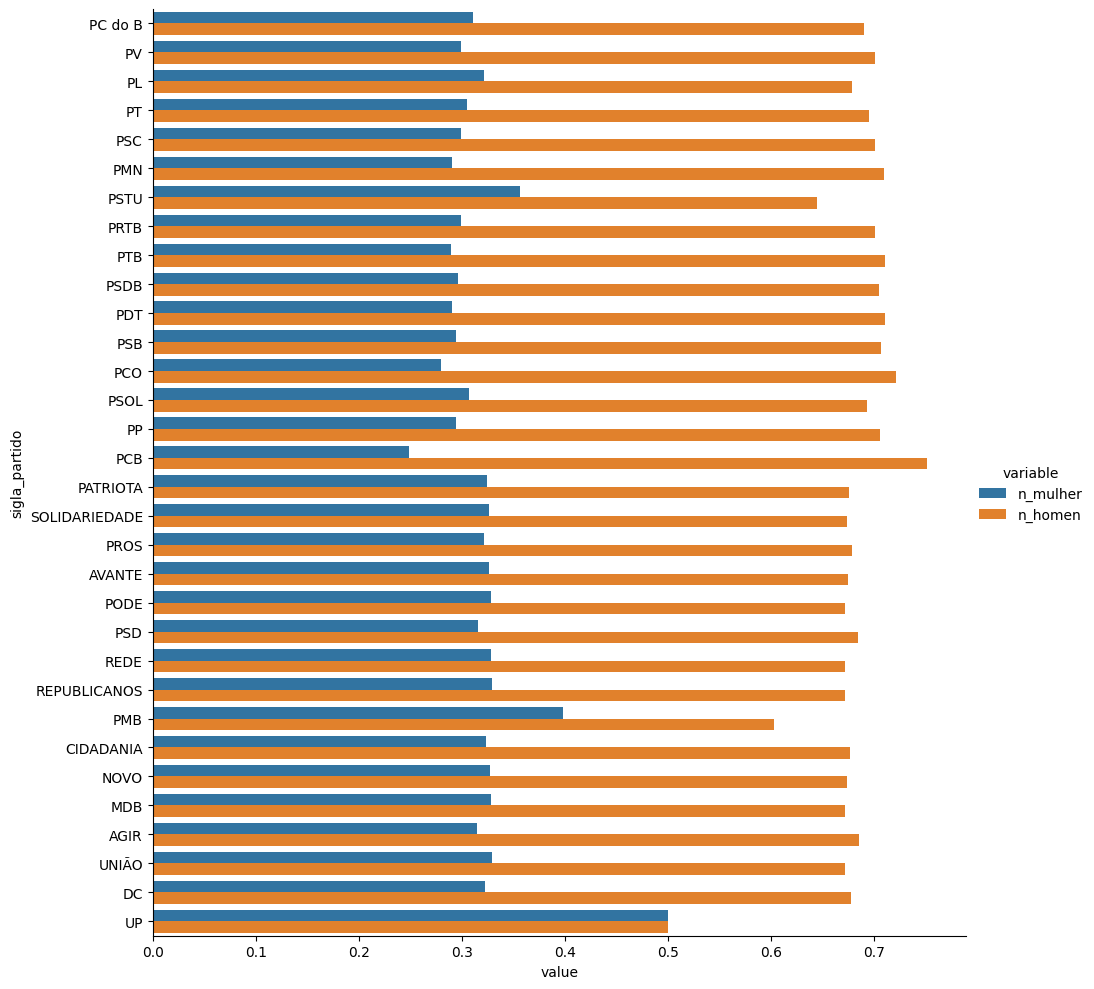

In [15]:
sns.catplot(df_gen.melt(id_vars="sigla_partido"), kind='bar',
            y="sigla_partido", hue="variable", x="value",
            height=10)

sns.despine()

Vemos que genero é irrelevante para determinar que partido a pessoa escolherá

### Etnia

In [16]:
query = f"""
SELECT
    sigla_partido,
    COUNT(CASE WHEN raca='branca' THEN 1 END)/COUNT(estado_civil) AS n_branca,
    COUNT(CASE WHEN raca='parda' THEN 1 END)/COUNT(estado_civil) AS n_parda,
    COUNT(CASE WHEN raca='preta' THEN 1 END)/COUNT(estado_civil) AS n_preta,
    COUNT(CASE 
        WHEN 
            raca <> 'branca' AND
            raca <> 'parda' AND
            raca <> 'preta'
        THEN 1 END)/COUNT(raca) AS outros
FROM
    {tb_candidatos}
WHERE
    {cond_target} AND
    ano >=2014
GROUP BY
    sigla_partido
"""
df_raca = read_sql(query)

Downloading: 100%|████████████████████████████| 32/32 [00:00<00:00, 77.49rows/s]


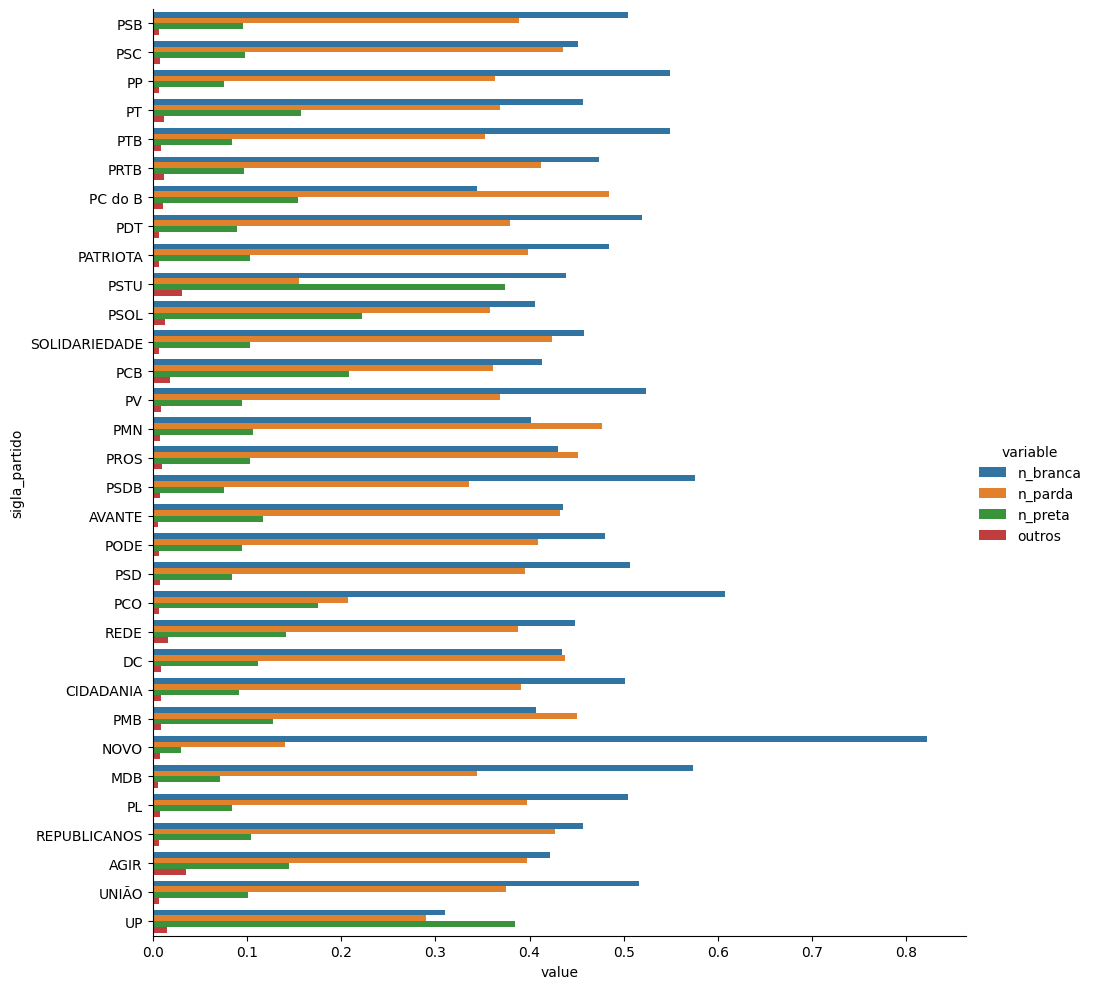

In [17]:
sns.catplot(df_raca.melt(id_vars="sigla_partido"), kind='bar',
            y="sigla_partido", hue="variable", x="value",
            height=10)

sns.despine()

### Estado civil

In [18]:
query = f"""
SELECT
    sigla_partido,
    COUNT(CASE WHEN estado_civil='solteiro(a)' THEN 1 END)/COUNT(estado_civil) AS n_solteiro,
    COUNT(CASE WHEN estado_civil='casado(a)' THEN 1 END)/COUNT(estado_civil) AS n_casado,
    COUNT(CASE WHEN estado_civil <> 'solteiro(a)' OR estado_civil='casado(a)' THEN 1 END)/COUNT(estado_civil) AS outros,
FROM
    {tb_candidatos}
WHERE
    {cond_target}
GROUP BY
    sigla_partido
"""
df_estado_civil = read_sql(query)

Downloading: 100%|████████████████████████████| 32/32 [00:00<00:00, 99.06rows/s]


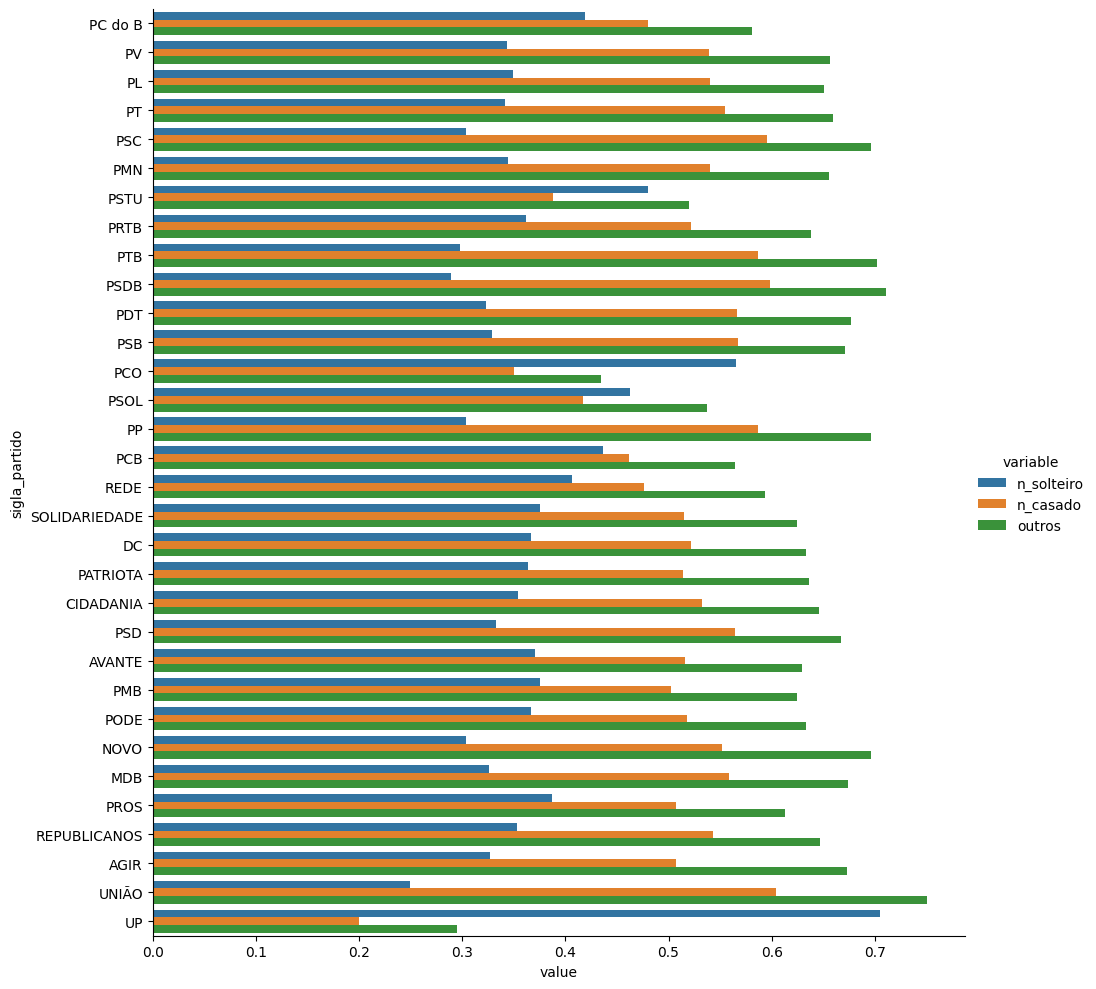

In [19]:
sns.catplot(df_estado_civil.melt(id_vars="sigla_partido"), kind='bar',
            y="sigla_partido", hue="variable", x="value",
            height=10)

sns.despine()